# Convolutional Neural Networks for classification

-- Prof. Dorien Herremans

We will be demonstrating the use of CNNs for image classification. This tutorial will use the Keras library, built upon Tensorflow version 1.x 

Since CNNs can benefit from using GPU power, please change your runtime to GPU. It will make things to 10x as fast. You can do it using the Runtime menu in Google Colab. 

In [0]:
# If Keras is not installed, please do so with the command below: 
!pip install keras

# This notebook is built around using tensorflow 1.0 as the backend for keras
!KERAS_BACKEND=tensorflow python -c "from tensorflow.keras import backend"

We will be performing a 2-class classification problem: classifying dogs versus cats from images. Our dataset is based on the Kaggle dataset https://www.kaggle.com/c/dogs-vs-cats/data. Do **not** use this dataset, however, as it is very big and will take too long to train. 

**Please download the reduced dataset from dorienherremans.com/drop -> cds / cnns/ catsanddogs. This reduced dataset contains 1,000 training examples for each class, and 400 validation examples for each class.

In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
preview/
```


Notice how the labels of the images are, in fact, the folders. You can use any other types of labels/images to train this model and it will adapt accordingly...


Let's download the dataset: 


In [0]:
!wget -P / -c "https://dorienherremans.com/drop/CDS/CNNs/cat_dog.zip"

--2019-12-10 02:23:27--  https://dorienherremans.com/drop/CDS/CNNs/cat_dog.zip
Resolving dorienherremans.com (dorienherremans.com)... 96.127.180.74
Connecting to dorienherremans.com (dorienherremans.com)|96.127.180.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64180857 (61M) [application/zip]
Saving to: ‘cat_dog.zip’

at_dog.zip          100%[===================>]  61.21M  14.3MB/s    in 5.6s    

2019-12-10 02:23:33 (11.0 MB/s) - ‘cat_dog.zip’ saved [64180857/64180857]



Unzip the file you just downloaded. This will extract everything in the folder structure described above. 


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('./cat_dog.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

Loading the necessary libraries for the lab: 

In [0]:
%tensorflow_version 1.x

import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
from keras.callbacks import History 

Using TensorFlow backend.


Next, we'll store the training and validation data path in two variables. We'll also store the image resolution in two variables: 

In [0]:
img_width, img_height = 150, 150
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# Simple CNN

Let's preprocess the data before we feed them to the CNN. We will use 'generators' to feed batches of images to the network. All of these are rescaled to 150x150 and the pixel values are normalised to be between 0 and 1 (instead of 0 and 255). 

In [0]:
# rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Model architecture
Now we are ready to define our model architecture. We'll use a three layered convolutional network with ReLu units and pooling. On top of the three convolutional layers, we add two fully-connected layers.

In [0]:
# a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling # in Keras, sequential model means a linear stack of layers. Which is what we are doing
model = Sequential()
# We add three convolution layers, each consisting of ReLu
# units and pooling with a window of (2,2)
#32 filters, kernel size (3,3)
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In order to facilitate binary classification, we end the model with a single unit that uses sigmoid activation. Training will be done by minimising the binary_crossentropy loss and using an RmsProp optimizer. Alternatives include Adam optimizer and others, see: https://keras.io/optimizers/

In [0]:
# specify training loss function 
model.compile(loss='binary_crossentropy',
optimizer='rmsprop',
metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Training

Let's train this simple model for a few epochs. I recommend as many epochs as your computer can handle, but put it to very few the first time you run. (It can be time consuming: about 3-60 seconds an epoch, so definitely use GPU!) We sample (randomly select) 2048 images from the dataset as training, and 832 as validation. 


In [0]:
epochs = 30
train_samples = 2048
validation_samples = 832

In [0]:
history = History() # this will allow us to plot the evolution of the validation loss
model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    callbacks=[history], # save the history so that we can plot it later
    validation_data=validation_generator,
    validation_steps=validation_samples// batch_size,)




Epoch 1/30





64/64 [==============================] - 15s 232ms/step - loss: 0.7371 - acc: 0.5307 - val_loss: 0.6751 - val_acc: 0.6550
Epoch 2/30
64/64 [==============================] - 7s 113ms/step - loss: 0.6648 - acc: 0.6299 - val_loss: 0.6377 - val_acc: 0.6286
Epoch 3/30
64/64 [==============================] - 7s 114ms/step - loss: 0.6082 - acc: 0.6748 - val_loss: 0.6169 - val_acc: 0.6863
Epoch 4/30
64/64 [==============================] - 7s 113ms/step - loss: 0.5717 - acc: 0.6997 - val_loss: 0.6100 - val_acc: 0.6550
Epoch 5/30
64/64 [==============================] - 7s 111ms/step - loss: 0.5192 - acc: 0.7461 - val_loss: 0.6368 - val_acc: 0.6755
Epoch 6/30
64/64 [==============================] - 7s 113ms/step - loss: 0.4708 - acc: 0.7788 - val_loss: 0.5753 - val_acc: 0.7296
Epoch 7/30
64/64 [==============================] - 7s 112ms/step - loss: 0.4247 - acc: 0.8076 - val_loss: 0.5967 - val_acc: 0.7188
Epoch 8/30
64/64 [==============================] - 7s 112ms/step -

After this long a wait you will want to save your weights! This way you can reuse your model without training it again: 

In [0]:
model.save_weights('basic_cnn_30_epochs.h5')

And later, when you want to load the saved model you can just call it like this without having to train it again: 

In [0]:
#model.load_weights('basic_cnn_30_epochs.h5')

### Evaluating the model during training

Now that we have trained our model, let's see how well it performs. Because we've added the argument callbacks=[history] to our generator object, the loss was saved at each step during training and we can retrieve it from a variable called history. Below we plot the different variables in the history object during training: 

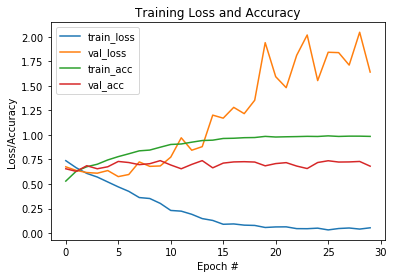

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# plot the training loss and accuracy
def plotResults(): 
    plt.figure()
    N = epochs
    
    # TODO: plot the accuracy/loss variables over training time

    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")

    # make the graph understandable: 
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")
    plt.show()
    
plotResults()

After ~10 epochs the neural network reaches ~75% accuracy. We can witness overfitting, as no progress is made on the validation set in the next epochs.

# Augmented data model

Overfitting can possibly be remedies by augmenting our dataset so that our model becomes more robust. Let's take a random image of a cat again and display it: 


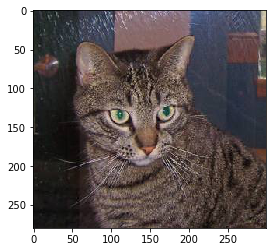

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = load_img('./data/train/cats/cat.1.jpg')

# Show the image:
imgplot = plt.imshow(img)
plt.show()

She's cute and looks like my cat [Sendai](https://www.facebook.com/Sendai-251531448370007/) (who is sadly still in Belgium). Unlike Sendai, who likes posing for the camera, we only have one shot of this cat. So let's augment this image into multiple slightly different images...

Keras contains a preprocessing library. This provides us with a number of operations, including: 

* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

More options available in the documentation: http://keras.io/preprocessing/image/

Let's test this out on the cat image: 

In [0]:
# change the characteristics to augment the data in different way if you want to explore...
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# load the original image
img = load_img('./data/train/cats/cat.1.jpg')
# reshape the image to a numpy array
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
# this will execute the flow function 20 times.
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='cat', save_format='jpg'):
    i += 1
    if i > 19:
        break # otherwise the generator would loop indefinitely

This has put the images in our preview/ folder. You can check in your filemanager or via: 

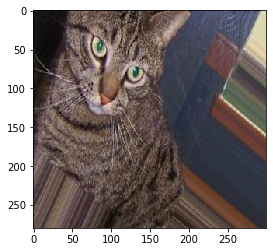

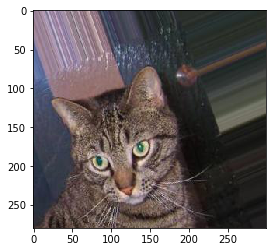

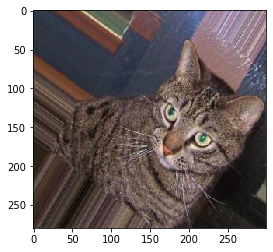

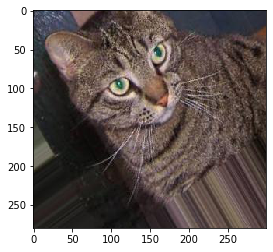

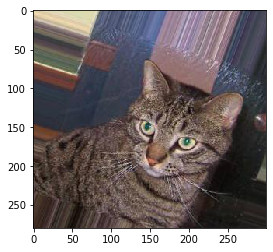

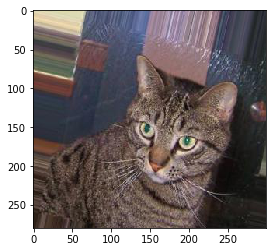

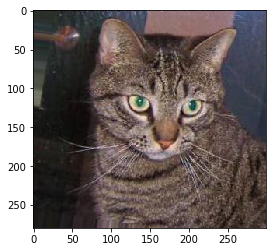

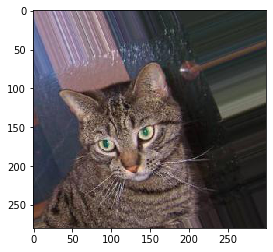

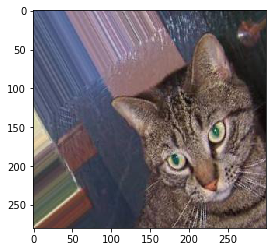

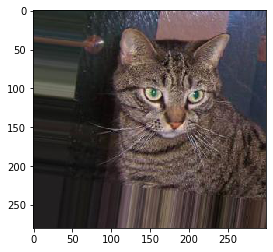

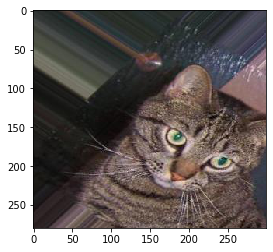

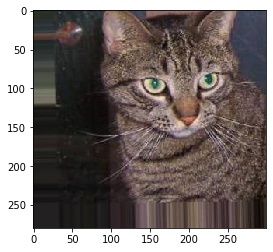

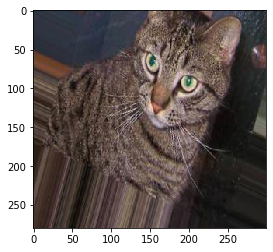

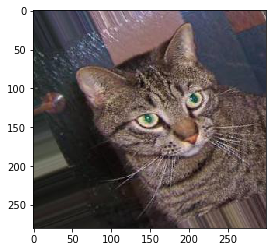

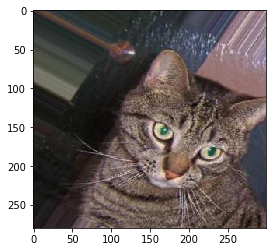

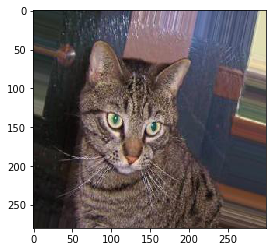

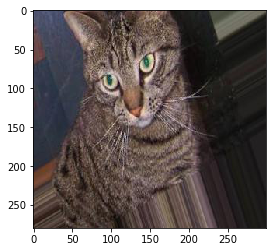

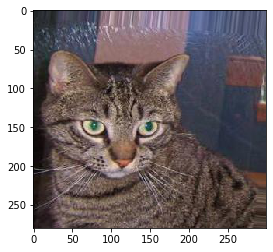

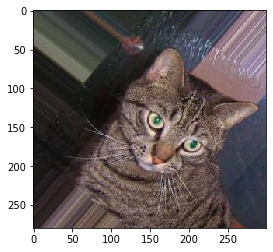

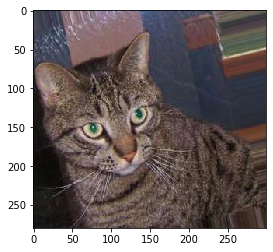

In [0]:
from PIL import Image
import glob
for filename in glob.glob('preview/*.jpg'):
    img=Image.open(filename)
    imgplot = plt.imshow(img)
    plt.show()   

Great! Notice how the cat images are mirrored, skewed and generally deformed. This will allow our model to train more robustly. 

Now it's time to fit the new data into the model in Keras. We will be downscaling all the images to 150x150 pixels so that they are all the same size. We will use the same 3 layered model with ReLu nodes and pooling that was previously defined. 

Now we can integrate this in our previous data preprocessing as follows: 

In [0]:
# slightly adapted the variables for data augmentation:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255, # normalize pixel values to [0,1]
    shear_range=0.2, # randomly applies shearing transformation
    zoom_range=0.2, # randomly applies shearing transformation
    horizontal_flip=True) # randomly flip the images
# almost same code as before exept first line
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's train the model. Remember adjust the (previously set) batch size variable to make the training shorter or longer...

In [0]:
history = History() # this will allow us to plot the evolution of the validation loss
model.fit_generator(
    train_generator_augmented,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    callbacks=[history], # save the history so that we can plot it later
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size,)

Epoch 1/30
64/64 [==============================] - 15s 242ms/step - loss: 0.5689 - acc: 0.7578 - val_loss: 0.6043 - val_acc: 0.7344
Epoch 2/30
64/64 [==============================] - 14s 222ms/step - loss: 0.5360 - acc: 0.7573 - val_loss: 0.5735 - val_acc: 0.7488
Epoch 3/30
64/64 [==============================] - 14s 225ms/step - loss: 0.5364 - acc: 0.7749 - val_loss: 0.5637 - val_acc: 0.7163
Epoch 4/30
64/64 [==============================] - 14s 224ms/step - loss: 0.4619 - acc: 0.7998 - val_loss: 0.6565 - val_acc: 0.7260
Epoch 5/30
64/64 [==============================] - 14s 221ms/step - loss: 0.4801 - acc: 0.7798 - val_loss: 0.6339 - val_acc: 0.7392
Epoch 6/30
64/64 [==============================] - 14s 221ms/step - loss: 0.4462 - acc: 0.8057 - val_loss: 0.5438 - val_acc: 0.7584
Epoch 7/30
64/64 [==============================] - 14s 224ms/step - loss: 0.4575 - acc: 0.8008 - val_loss: 0.5882 - val_acc: 0.7572
Epoch 8/30
64/64 [==============================] - 14s 221ms/step - 

Save the trained model: 

In [0]:
model.save_weights('augmented_30_epochs.h5')

How does this model perform? (We use the function we defined earlier.)

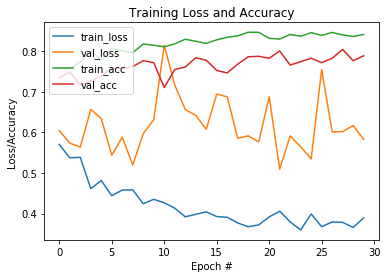

In [0]:
plotResults()

Excellent, you have trained a CNN with augmented data! The accuracy is much higher and surpasses 80%

Now let's see if we can use this model to get the class prediction for one particular image: 

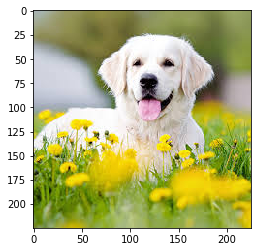

In [0]:
# Is this a dog or a cat? 
img = load_img('./data/test/test.jpg')  # this is a PIL image
imgplot = plt.imshow(img)
plt.show()

Now let's predict the class this image belongs to: 

In [0]:
# if you need to install cv2 you can use:
!pip install opencv-python
import cv2
testimg = cv2.imread('data/test/test.jpg')
testimg = cv2.resize(testimg,(150,150))
# data preprocessing to get the input in the same shape
x = img_to_array(testimg) # this is a Numpy array with shape (3, x, y)
x = x * 1./255
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, x, y)
predictedclass = model.predict_classes(x)
# cats are class 0; dogs are class 1 as you can see from command below
# it's always good to check this for a new dataset
# print(train_generator.class_indices)
# making the output a bit nicer.
if predictedclass == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
print(prediction)

dog


It worked! Do you have a picture of your pet? Give it a go and see if your model can predict..

Note: if you did not train your model very long, it won't be accurate. For real applications, you may want to try a pretrained model (see below). .

# Advanced pretrained model (optional and FYI)

Some very accurate image recognition models have been built based on a lot of data. It will often improve your results if you start from a saved pretrained model and further finetune this using your data. The below code is meant as an example of how you may do this. There are many different pretrained models out there. Find one that is right for your data... 

We use the pretrained model on ImageNet data which is available at https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3 (no need to download, the script will automatically fetch the data for you. The module architecture of the model (VGG) we are loading is as follows: 
![alt text](https://blog.keras.io/img/imgclf/vgg16_modified.png "Title")


The VGG16 model is available in Keras: 

To use VGG16 for image classification, we define datagenerators like before: 

This is a long process, so we save the output of the VGG16. 

Now we can load it...

And define and train the custom fully connected neural network which follows the convolutional layers: 

The training process of this small neural network is very fast : ~3s per epoch

Let's evaluate this model. Evolution of accuracy on training (blue) and validation (green) sets for 1 to 32 epochs : 

**We reached 90-95% accuracy on the validation after ~20 epochs and using only 8% of the samples originally available on the Kaggle competition!**

## References
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
* https://blog.keras.io/img/imgclf/
<!--https://github.com/rajshah4/image_keras/blob/master/notebook.ipynb-->
